In [4]:
import pandas as pd

# Upload from local computer
from google.colab import files
uploaded = files.upload()

# Load into DataFrame
df = pd.read_csv("traffic_counts.csv")
df.head()

Saving traffic_counts.csv to traffic_counts (1).csv


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,32970,Queens,2021,4,30,2,0,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
1,32970,Queens,2021,4,30,2,15,1,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
2,11342,Brooklyn,2012,12,18,8,15,33,20063,POINT (985746.5 167127.4),61 ST,15 AV,16 AV,WB
3,32970,Queens,2021,4,30,2,30,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
4,32970,Queens,2021,4,30,2,45,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB


In [9]:
df['datetime'] = pd.to_datetime(
    df[['Yr', 'M', 'D', 'HH', 'MM']].rename(
        columns={'Yr': 'year', 'M': 'month', 'D': 'day', 'HH': 'hour', 'MM': 'minute'})
)

In [10]:
# Check missing values
print(df.isnull().sum())

# Drop rows with any missing values
df.dropna(inplace=True)

RequestID      0
Boro           0
Yr             0
M              0
D              0
HH             0
MM             0
Vol            0
SegmentID      0
WktGeom        0
street         0
fromSt         0
toSt         133
Direction      0
datetime       0
dtype: int64


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
from shapely import wkt

df['geometry'] = df['WktGeom'].apply(wkt.loads)
df[['longitude', 'latitude']] = df['geometry'].apply(lambda g: pd.Series([g.x, g.y]))

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Vol_scaled'] = scaler.fit_transform(df[['Vol']])


In [14]:
df = pd.get_dummies(df, columns=['Boro', 'Direction'], drop_first=True)


In [15]:
df.to_csv("traffic_cleaned.csv", index=False)

In [16]:
from google.colab import files
files.download("traffic_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
df['hour'] = df['datetime'].dt.hour


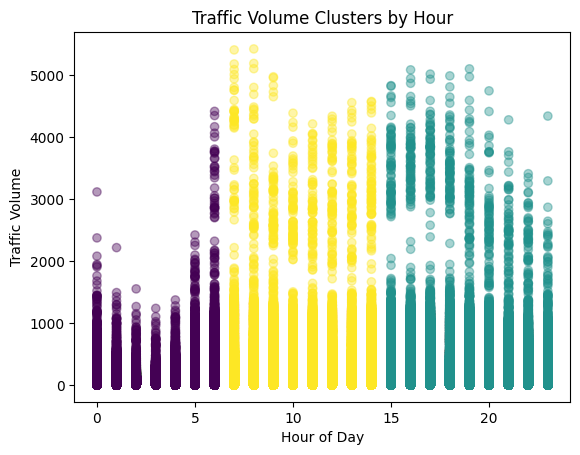

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Features
X = df[['Vol_scaled', 'datetime']].copy()
X['hour'] = df['datetime'].dt.hour

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X[['Vol_scaled', 'hour']])

# Visualize
plt.scatter(df['hour'], df['Vol'], c=df['cluster'], cmap='viridis', alpha=0.4)
plt.xlabel("Hour of Day")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Clusters by Hour")
plt.show()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute

X = df[['hour', 'minute']]
y = df['Vol']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 36083.61


In [22]:
print(df['Vol'].describe())


count    1.048442e+06
mean     1.154995e+02
std      1.945059e+02
min      0.000000e+00
25%      1.900000e+01
50%      6.000000e+01
75%      1.370000e+02
max      5.425000e+03
Name: Vol, dtype: float64


In [23]:
import numpy as np
rmse = np.sqrt(36083.61)
print(f"RMSE: {rmse:.2f}")


RMSE: 189.96


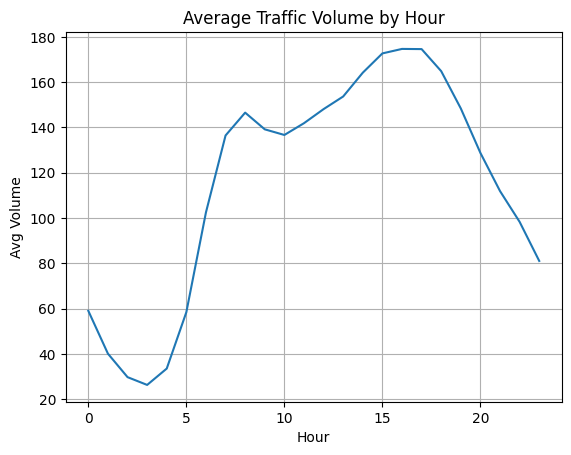

In [24]:
import seaborn as sns

df['hour'] = df['datetime'].dt.hour
hourly_avg = df.groupby('hour')['Vol'].mean().reset_index()

sns.lineplot(data=hourly_avg, x='hour', y='Vol')
plt.title("Average Traffic Volume by Hour")
plt.ylabel("Avg Volume")
plt.xlabel("Hour")
plt.grid(True)
plt.show()